# Experiment2
`Anomaly detection` base code: [Auto-CNN](https://www.kaggle.com/code/thomasdubail/auto-cnn)

# 1. Load packages

In [1]:
%load_ext autoreload
%autoreload 2

from analysis_tools.common import *
from util import *

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import sklearn
import cv2
import os

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
sklearn.random.seed(RANDOM_STATE)

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


# 2. Load dataset

## 2.1 Bottle

In [2]:
class_sample = 'screw'

In [3]:
@delayed
def load_img(path, size):
    return cv2.resize(cv2.imread(path), (size, size))

SIZE        = 256
INPUT_SHAPE = (SIZE, SIZE, 3)
train_full_data_meta = pd.read_csv(join(PATH.input, 'train_df.csv'), index_col=0)
train_full_data_meta = train_full_data_meta.query(f"`class` == '{class_sample}'")
paths                = train_full_data_meta['file_name']
with ProgressBar():
    X_train_full = np.array(compute(*[load_img(join(PATH.train, path), SIZE) for path in paths]))
    y_train_full = train_full_data_meta['state'].values

[########################################] | 100% Completed |  0.7s


In [4]:
from sklearn.model_selection import train_test_split

X_normal   = X_train_full[y_train_full == 'good']
X_abnormal = X_train_full[y_train_full != 'good']
X_train, X_test = train_test_split(X_normal)
X_train, X_val  = train_test_split(X_train)
X_test = np.concatenate([X_test, X_abnormal])

X_train = X_train / 255
X_val   = X_val / 255
X_test  = X_test / 255

print("X_train:", X_train.shape)  # normal
print("X_val:", X_val.shape)      # noraml + abnormal
print("X_test:", X_test.shape)    # noraml + abnormal

X_train: (180, 256, 256, 3)
X_val: (60, 256, 256, 3)
X_test: (141, 256, 256, 3)


In [5]:
BATCH_SIZE = 32

aug_model = keras.models.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

def preprocess(ds, training, batch_size, augment=True):
    ds = ds.cache().batch(batch_size)
    if training:
        ds = ds.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
        if augment:
            ds = ds.map(lambda x, y: (aug_model(x), aug_model(y)), num_parallel_calls=tf.data.AUTOTUNE)
    return ds

ds_train = preprocess(tf.data.Dataset.from_tensor_slices((X_train, X_train)), True, BATCH_SIZE, augment=False)
ds_val   = preprocess(tf.data.Dataset.from_tensor_slices((X_val, X_val)), False, BATCH_SIZE, augment=False)

# 3. Training

In [6]:
from tensorflow.keras import layers
from functools import partial

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

conv  = partial(layers.Conv2D, kernel_size=3, strides=2, padding='same', kernel_initializer='lecun_normal', activation='selu')
convt = partial(layers.Conv2DTranspose, kernel_size=3, strides=2, padding='same', kernel_initializer='lecun_normal', activation='selu')

with strategy.scope():
    encoder = keras.models.Sequential([
        layers.Input(INPUT_SHAPE),
        conv(32),
        conv(64),
        conv(128),
#         conv(256),
#         conv(512),
    ])
    decoder = keras.models.Sequential([
        layers.Input(encoder.output.shape[1:]),
#         convt(256),
#         convt(128),
        convt(64),
        convt(32),
        convt(3, activation='sigmoid', kernel_initializer='glorot_normal')
    ])
    ae = keras.models.Sequential([encoder, decoder])
    ae.compile(loss='binary_crossentropy', optimizer='adam', metrics=[rounded_accuracy])
    
    encoder.summary()
    decoder.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)     

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

H = ae.fit(ds_train, validation_data=ds_val, epochs=100, callbacks=[EarlyStopping(patience=20)])

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/

Epoch 98/100
6/6 [==============================] - 1s 137ms/step - loss: 0.5492 - rounded_accuracy: 0.9896 - val_loss: 0.5555 - val_rounded_accuracy: 0.9895
Epoch 99/100
6/6 [==============================] - 1s 147ms/step - loss: 0.5491 - rounded_accuracy: 0.9898 - val_loss: 0.5556 - val_rounded_accuracy: 0.9899
Epoch 100/100
6/6 [==============================] - 1s 147ms/step - loss: 0.5492 - rounded_accuracy: 0.9896 - val_loss: 0.5555 - val_rounded_accuracy: 0.9899


In [8]:
def show_reconstructions(model, images, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 10, 20))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index])
        plt.axis('off')
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index])
        plt.axis('off')

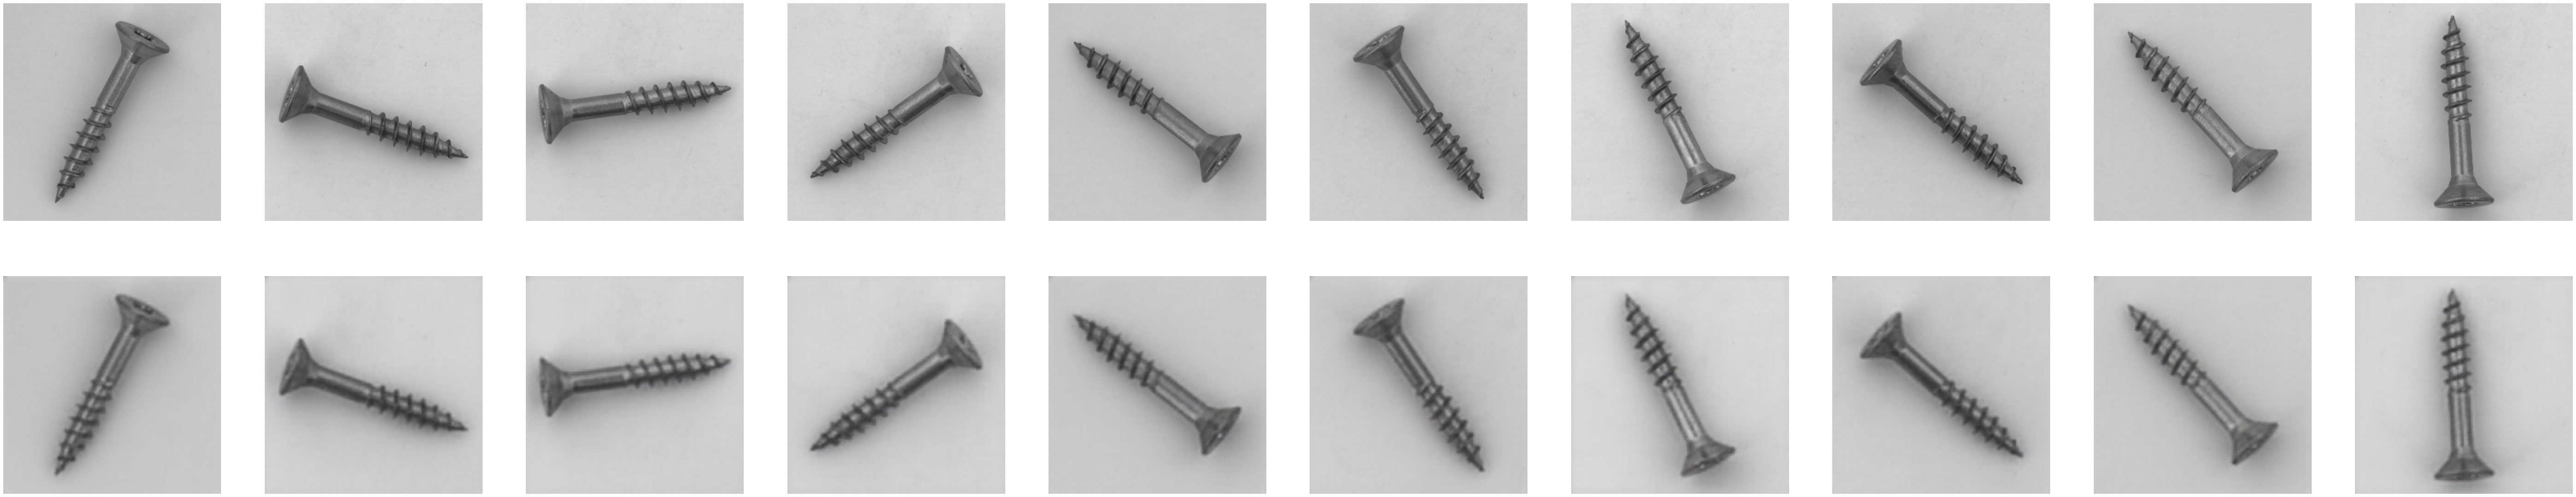

In [9]:
show_reconstructions(ae, X_train)

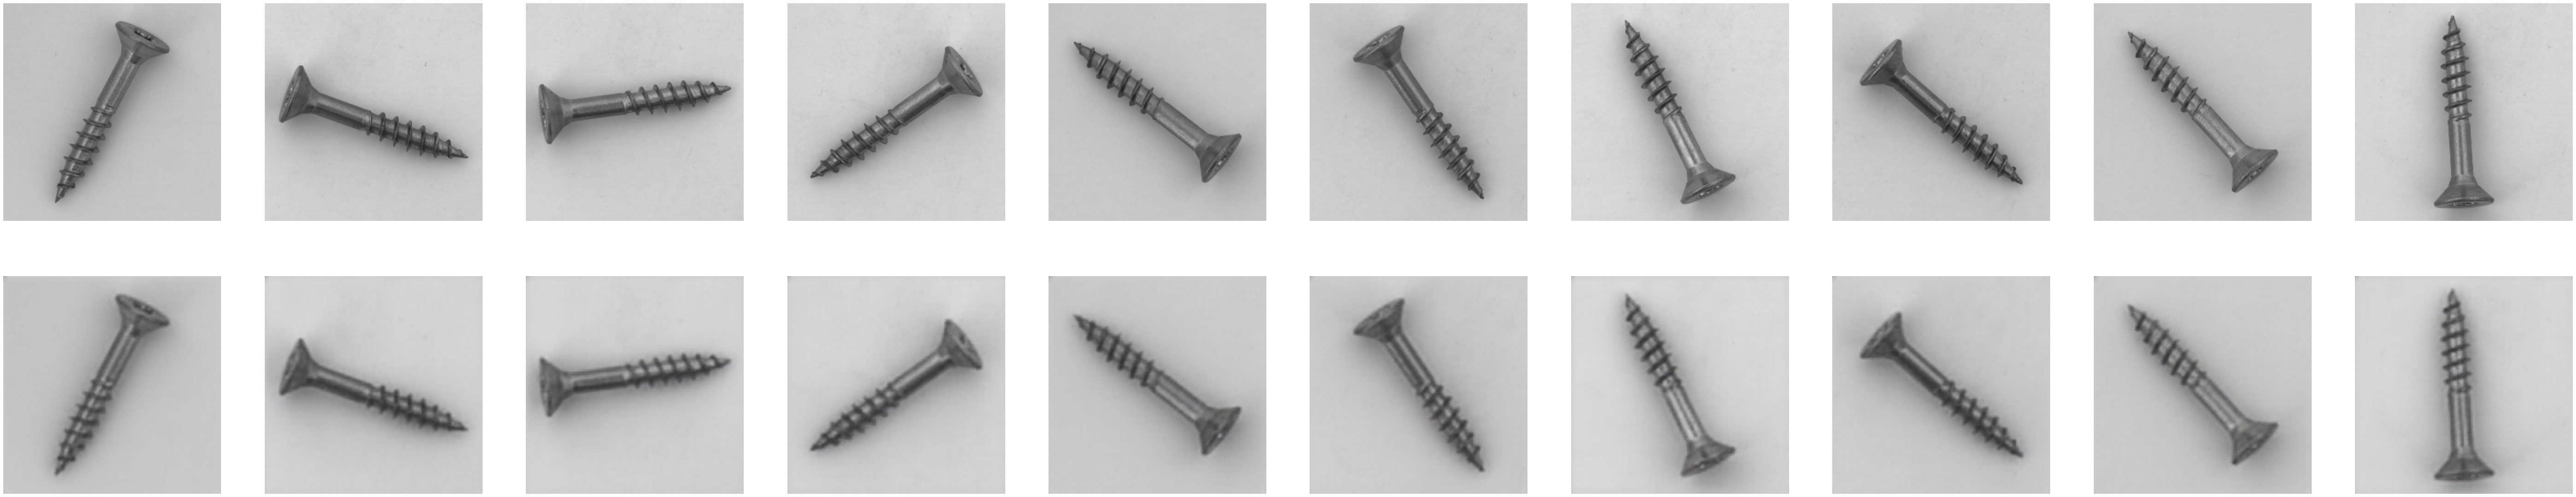

In [9]:
show_reconstructions(ae, X_test[-11:-1])

In [10]:
as

SyntaxError: invalid syntax (<ipython-input-10-1ca5879492b8>, line 1)

# Blank

In [ ]:
show_reconstructions(ae, X_val)

In [ ]:
show_reconstructions(ae, X_test)